In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from sparse_rf.algs.core import min_l1, min_l2, min_wl2
from sparse_rf.modules import make_X, make_W, make_A
from sparse_rf.util.dists import *
from sparse_rf.util.activations import *

In [2]:
m = 1000
n = 1000
d = 5
q = 2

ratio_train = 0.75

In [27]:
X = make_X(d, m, dist=uniform)
W = make_W(d, q, n, dist=normal)
X_train = X[:int(m*ratio_train), :]
X_test = X[int(m*ratio_train):, :]

A_train = make_A(X_train, W, active=fourier)
A_test = make_A(X_train, W, active=fourier)

In [28]:
b = np.random.randn(d)
b /= np.linalg.norm(b)
# y = (1+np.linalg.norm(X, axis=-1))**(-0.5)
y = np.matmul(X, b) + 0.3
y_train = y[:int(m*ratio_train)]
y_test = y[int(m*ratio_train):]

In [16]:
# L1
c_spgl1 = min_l1(A_train, y_train)

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001


In [22]:
ind_spgl1, = c_spgl1.nonzero()
100*len(ind_spgl1) / A_train.shape[1]

100.0

In [23]:
y_train_spgl1 = np.matmul(A_train, c_spgl1)
error_train_spgl1 = np.linalg.norm(y_train - y_train_spgl1)/ len(y_train)
y_test_spgl1 = np.matmul(A_test, c_spgl1)
error_test_spgl1 = np.linalg.norm(y_test - y_test_spgl1)/ len(y_test)

In [24]:
print(error_train_spgl1)
print(error_test_spgl1)

0.00021935164621569836
0.00031382363419825795


In [25]:
c_l2 = min_l2(A_train, y_train)

In [26]:
y_train_l2 = np.matmul(A_train, c_l2)
error_train_l2 = np.linalg.norm(y_train - y_train_l2)/ len(y_train)
y_test_l2 = np.matmul(A_test, c_l2)
error_test_l2 = np.linalg.norm(y_test - y_test_l2)/len(y_test)

In [27]:
print(error_train_l2)
print(error_test_l2)

2.1776917698379615e-09
0.020086426528168406


In [28]:
# weights for weighted min-norm solution
norm = np.linalg.norm(W, axis=1)**2
weight = np.concatenate((norm, norm), axis=-1)
D = np.diag(1.0/weight**4)
c_weighted = min_wl2(A_train, y_train, D)

In [29]:
y_train_weighted = np.matmul(A_train, c_weighted)
error_train_weighted = np.linalg.norm(y_train - y_train_weighted)/ len(y_train)
y_test_weighted = np.matmul(A_test, c_weighted)
error_test_weighted = np.linalg.norm(y_test - y_test_weighted)/len(y_test)

In [30]:
print(error_train_weighted)
print(error_test_weighted)

0.00024789605677552786
0.00036169557372791694


## Ensemble

In [29]:
def make_D(W):
    norm = np.linalg.norm(W, axis=1)**2
    weight = np.concatenate((norm, norm), axis=-1)
    D = np.diag(1.0/weight**4)
    return D

In [30]:
ns = np.arange(50, 2100, 50)

In [31]:
results = []
for n in ns:
    res = []
    for _ in range(5):
        Ws = [make_W(d, q, 1, dist=normal) for _ in range(n)]
        Ds = [make_D(W) for W in Ws]
        A_trains = [make_A(X_train, W, active=fourier) for W in Ws]
        A_tests = [make_A(X_test, W, active=fourier) for W in Ws]
        cs = [min_wl2(A_train, y_train, D) for A_train, D in zip(A_trains, Ds)]
        y_test_ensemble = np.mean(np.array([A_tests[i]@cs[i] for i in range(len(Ws))]), axis=0)
        res.append(np.linalg.norm(y_test_ensemble-y_test) / len(y_test))

    results.append(res)

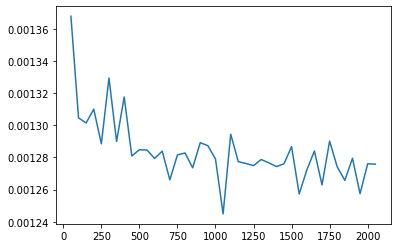

In [33]:
plt.plot(ns, [np.mean(res) for res in results])